### Make Figure 1 as Subplots

Emily Luschen \
28 Aug 2025

In [1]:
# import packages
import matplotlib.pyplot as plt # library for plotting
import matplotlib as mpl 
import numpy as np # libary for working with arrays
import xarray as xr
from scipy import stats
import pickle
import grl_functions as fun

In [7]:
storm = 'haiyan' # or 'maria'
ntime = 49 

if storm == 'haiyan':
    ntest = 4
    tests = ['ncrf36h', 'STRATANVIL_OFF', 'STRATANVIL_ON', 'STRAT_OFF']
    test_title = ['NCRF', 'SA-NCRF', 'C-NCRF', 'S-NCRF']
    nmem = 8
    t0_c = 36 # restart time
    az_name = 'AzWindTimeseriesAvgTrack'
    rh_name = '600hPaRHTimeseriesAvgTrack'
    vort_name = '600hPaVortTimeseriesAvgTrack'
elif storm == 'maria': # maria
    ntest = 1
    tests = ['ncrf48h'] 
    test_title = ['NCRF']
    nmem = 10
    t0_c = 48 # restart time
    az_name = 'MariaAzWindTimeseriesAvgTrack'
    rh_name = 'Maria600hPaRHTimeseriesAvgTrack'
    vort_name = 'Maria600hPaVortTimeseriesAvgTrack'

# data parameters
t0 = 0 # start time index
t1 = 49 # end time index
ntime = 49 # senstivity test time length
t1_c = t0_c + ntime
membs = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
w = 3 # running mean window size
nvar = 3 # number of variables

In [8]:
# Read in Data
azfile = azwind_pickle
with open(azfile, 'rb') as f:
        azwind_membs, azwind_membs_ctl = pickle.load(f)
# azwind_membs = np.squeeze(azwind_membs)

rhfile = rh_pickle
with open(rhfile, 'rb') as f:
        rh_mean_ctl, rh_mean = pickle.load(f)

vortfile = vort_pickle
with open(vortfile, 'rb') as f:
        avor_mean_ctl, avor_mean = pickle.load(f)

### Calculate Mean and Confidence intervals

In [10]:
# Smooth fields and calculate mean and confidence intervals

test_mean = [azwind_membs, rh_mean, avor_mean] # test x member x time
ctl_mean = [azwind_membs_ctl, rh_mean_ctl, avor_mean_ctl] # member x time

m_diff = np.zeros((nvar,ntest,ntime-2)) # variable x test x time(ntime-2 because of smoothing)
low_diff = np.zeros((nvar,ntest,ntime-2))
high_diff = np.zeros((nvar,ntest,ntime-2))

for v in range(nvar):
    # print(v)
    var_mean = test_mean[v].copy()
    var_mean_ctl = ctl_mean[v].copy()
    for s in range(len(tests)):
        var_diff = var_mean[s,:,:] - var_mean_ctl[:,t0_c:t1_c]
        var_diff_smooth = np.zeros((nmem, ntime-2))*np.nan
        for m in range(nmem):
            var_diff_smooth[m,:] = np.convolve(var_diff[m,:], (np.ones(w)/w), mode='valid') # smooth average; comment for no smoothing
        if storm == 'haiyan':
            m_diff[v,s,:], low_diff[v,s,:], high_diff[v,s,:] = fun.mean_confidence_interval(var_diff_smooth) # smooth average
        elif storm == 'maria':
            ind_list = [0,2,3,4,5,6,8,9]
            m_diff[v,:], low_diff[v,:], high_diff[v,:] = fun.mean_confidence_interval(var_diff_smooth[ind_list]) # smooth average
        # m_diff[t,:], low_diff[t,:], high_diff[t,:] = mean_confidence_interval(avor_diff) # no smoothing


In [5]:
# # Maria
# # Smooth fields and calculate mean and confidence intervals

# w = 3

# test_mean = [azwind_membs, rh_mean, avor_mean] # test x member x time
# ctl_mean = [azwind_membs_ctl, rh_mean_ctl, avor_mean_ctl] # member x time

# m_diff = np.zeros((nvar,ntime-2)) # variable x test x time
# low_diff = np.zeros((nvar,ntime-2))
# high_diff = np.zeros((nvar,ntime-2))

# for v in range(nvar):
#     # print(v)
#     var_mean = test_mean[v].copy()
#     var_mean_ctl = ctl_mean[v].copy()
#     var_diff = var_mean[:,:] - var_mean_ctl[:,48:97]
#     # print(np.shape(var_diff))
#     var_diff_smooth = np.zeros((nmem, ntime-2))*np.nan
#     for m in range(nmem):
#         var_diff_smooth[m,:] = np.convolve(var_diff[m,:], (np.ones(w)/w), mode='valid') # smooth average; comment for no smoothing
#     ind_list = [0,2,3,4,5,6,8,9]
#     m_diff[v,:], low_diff[v,:], high_diff[v,:] = fun.mean_confidence_interval(var_diff_smooth[ind_list]) # smooth average
#     # m_diff[t,:], low_diff[t,:], high_diff[t,:] = mean_confidence_interval(avor_diff) # no smoothing

### 3-Panel Timeseries Plot (Figure 1)

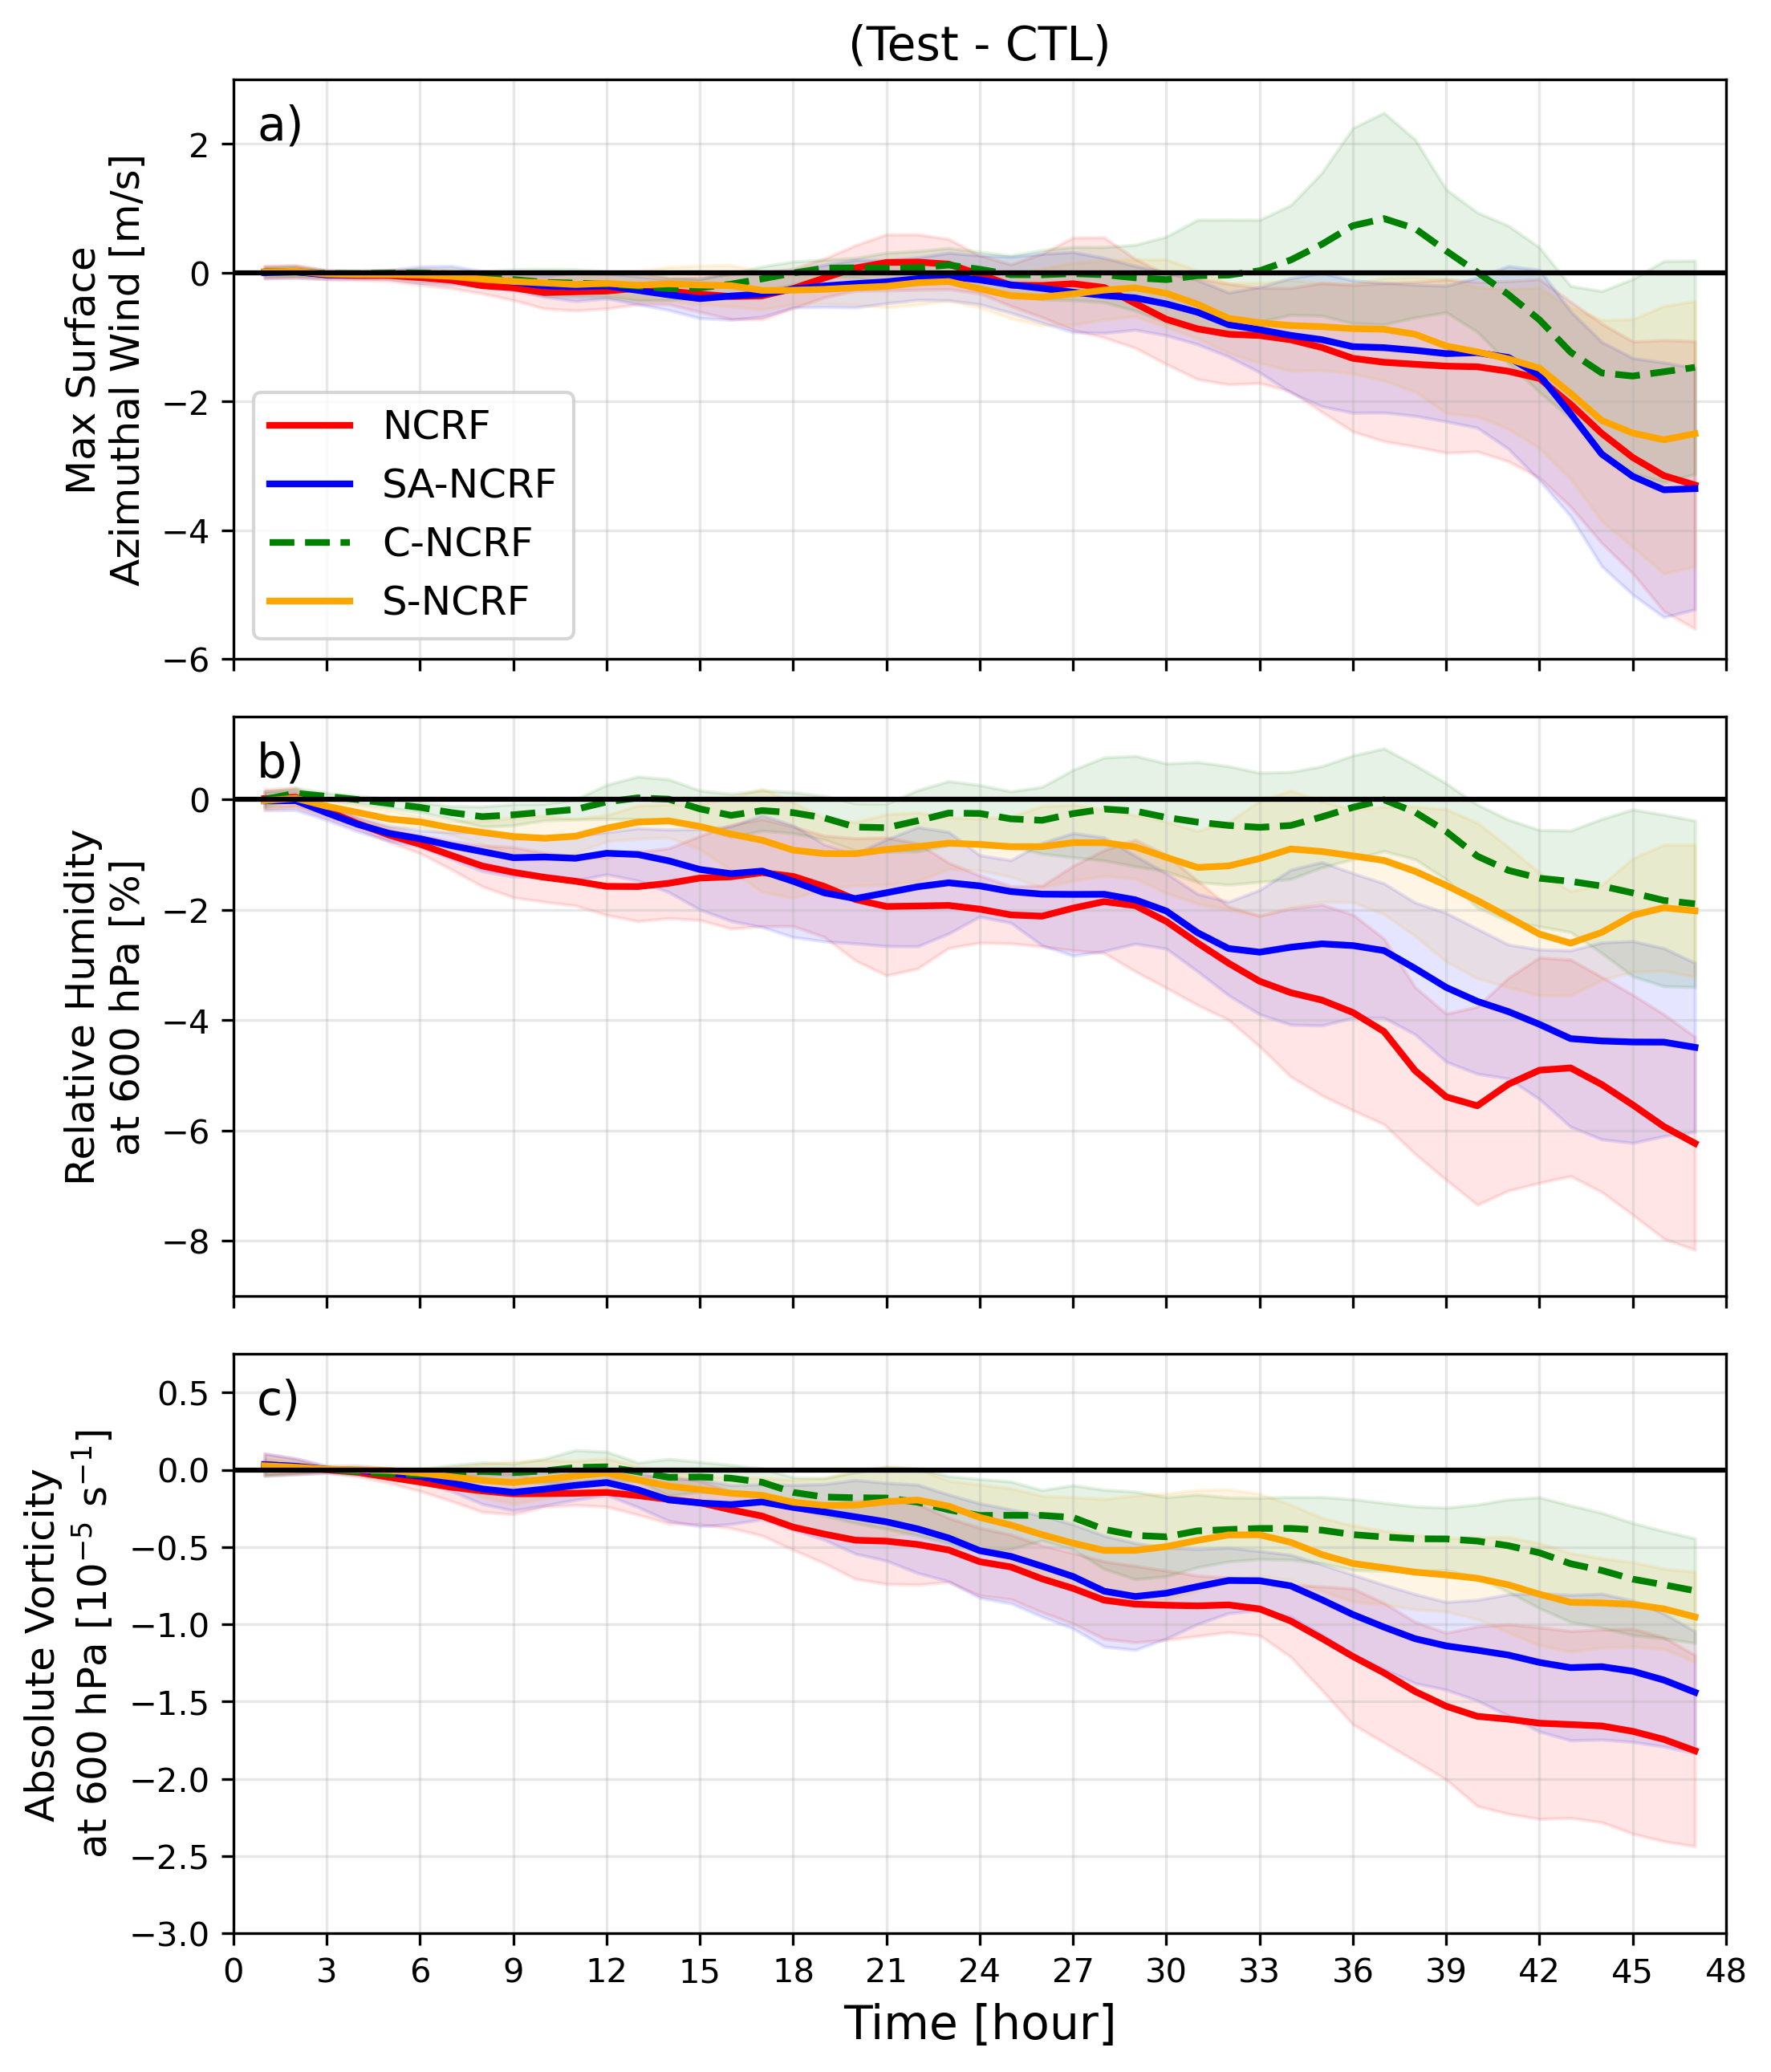

In [11]:
time_plt = np.arange(0,97,1)
tp0 = t0_c+1
tp1 = t1_c-1
label_list = ['a)', 'b)', 'c)']

fig = plt.figure(figsize=(8,10), dpi=300)
axs = fig.subplots(3,1)
for v in range(nvar):
    ax = axs[v]
    if v == 0:
        varlab = 'Max Surface\nAzimuthal Wind [m/s]'
        if storm == 'haiyan':
            varmax = 3
            varmin = -6
        elif storm == 'maria':
            varmax = 2
            varmin = -8
    elif v == 1:
        varlab = 'Relative Humidity\nat 600 hPa [%]'
        if storm == 'haiyan':
            varmax = 1.5
            varmin = -9
        elif storm == 'maria':
            varmax = 1
            varmin = -6
    elif v == 2:
        varlab = 'Absolute Vorticity\nat 600 hPa [10$^{-5}$ s$^{-1}$]'
        if storm == 'haiyan':
            varmax = 0.75
            varmin = -3
        elif storm == 'maria':
            varmax = 0.75
            varmin = -2
    colors = ['r', 'b', 'g', 'orange']
    for s in range(len(tests)):
        if tests[s] == 'STRATANVIL_ON':
            ls = '--'
        else:
            ls = '-'
        ax.plot(time_plt[tp0:tp1], m_diff[v,s,:], lw=2, linestyle=ls, color=colors[s], label=test_title[s])
        ax.fill_between(time_plt[tp0:tp1], low_diff[v,s,:], high_diff[v,s,:], color=colors[s], alpha=0.1)
    ax.axhline(0, color='k')
    ax.set_ylim(varmin, varmax) 
    ax.set_xlim(tp0, tp1)
    ax.grid(True, alpha=0.3)
    t_ticks = np.arange(t0_c, t1_c, 3)
    ax.set_ylabel(varlab, fontsize=12)
    ax.annotate(label_list[v], xy=(0, 1), xycoords='axes fraction', xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize=14, verticalalignment='top')
    if v == 0:
        ax.legend(loc='lower left', fontsize=12)
        ax.set_xticks(t_ticks, labels=[])
        ax.set_title('(Test - CTL)', fontsize=14)
    if v == 1:
        ax.set_xticks(t_ticks, labels=[])
    if v == nvar-1:
        ax.set_xticks(t_ticks, labels=list(np.arange(0,49,3)))
        ax.set_xlabel('Time [hour]', fontsize=14)
plt.subplots_adjust(hspace=0.1)

### Variable by Member Plots (for CTL Only)

/scratch/eluschen/tmp/ipykernel_34543/729447225.py:22: RuntimeWarning: Mean of empty slice
  ens_ctl = np.nanmean(ens_mem_smooth, axis=0)


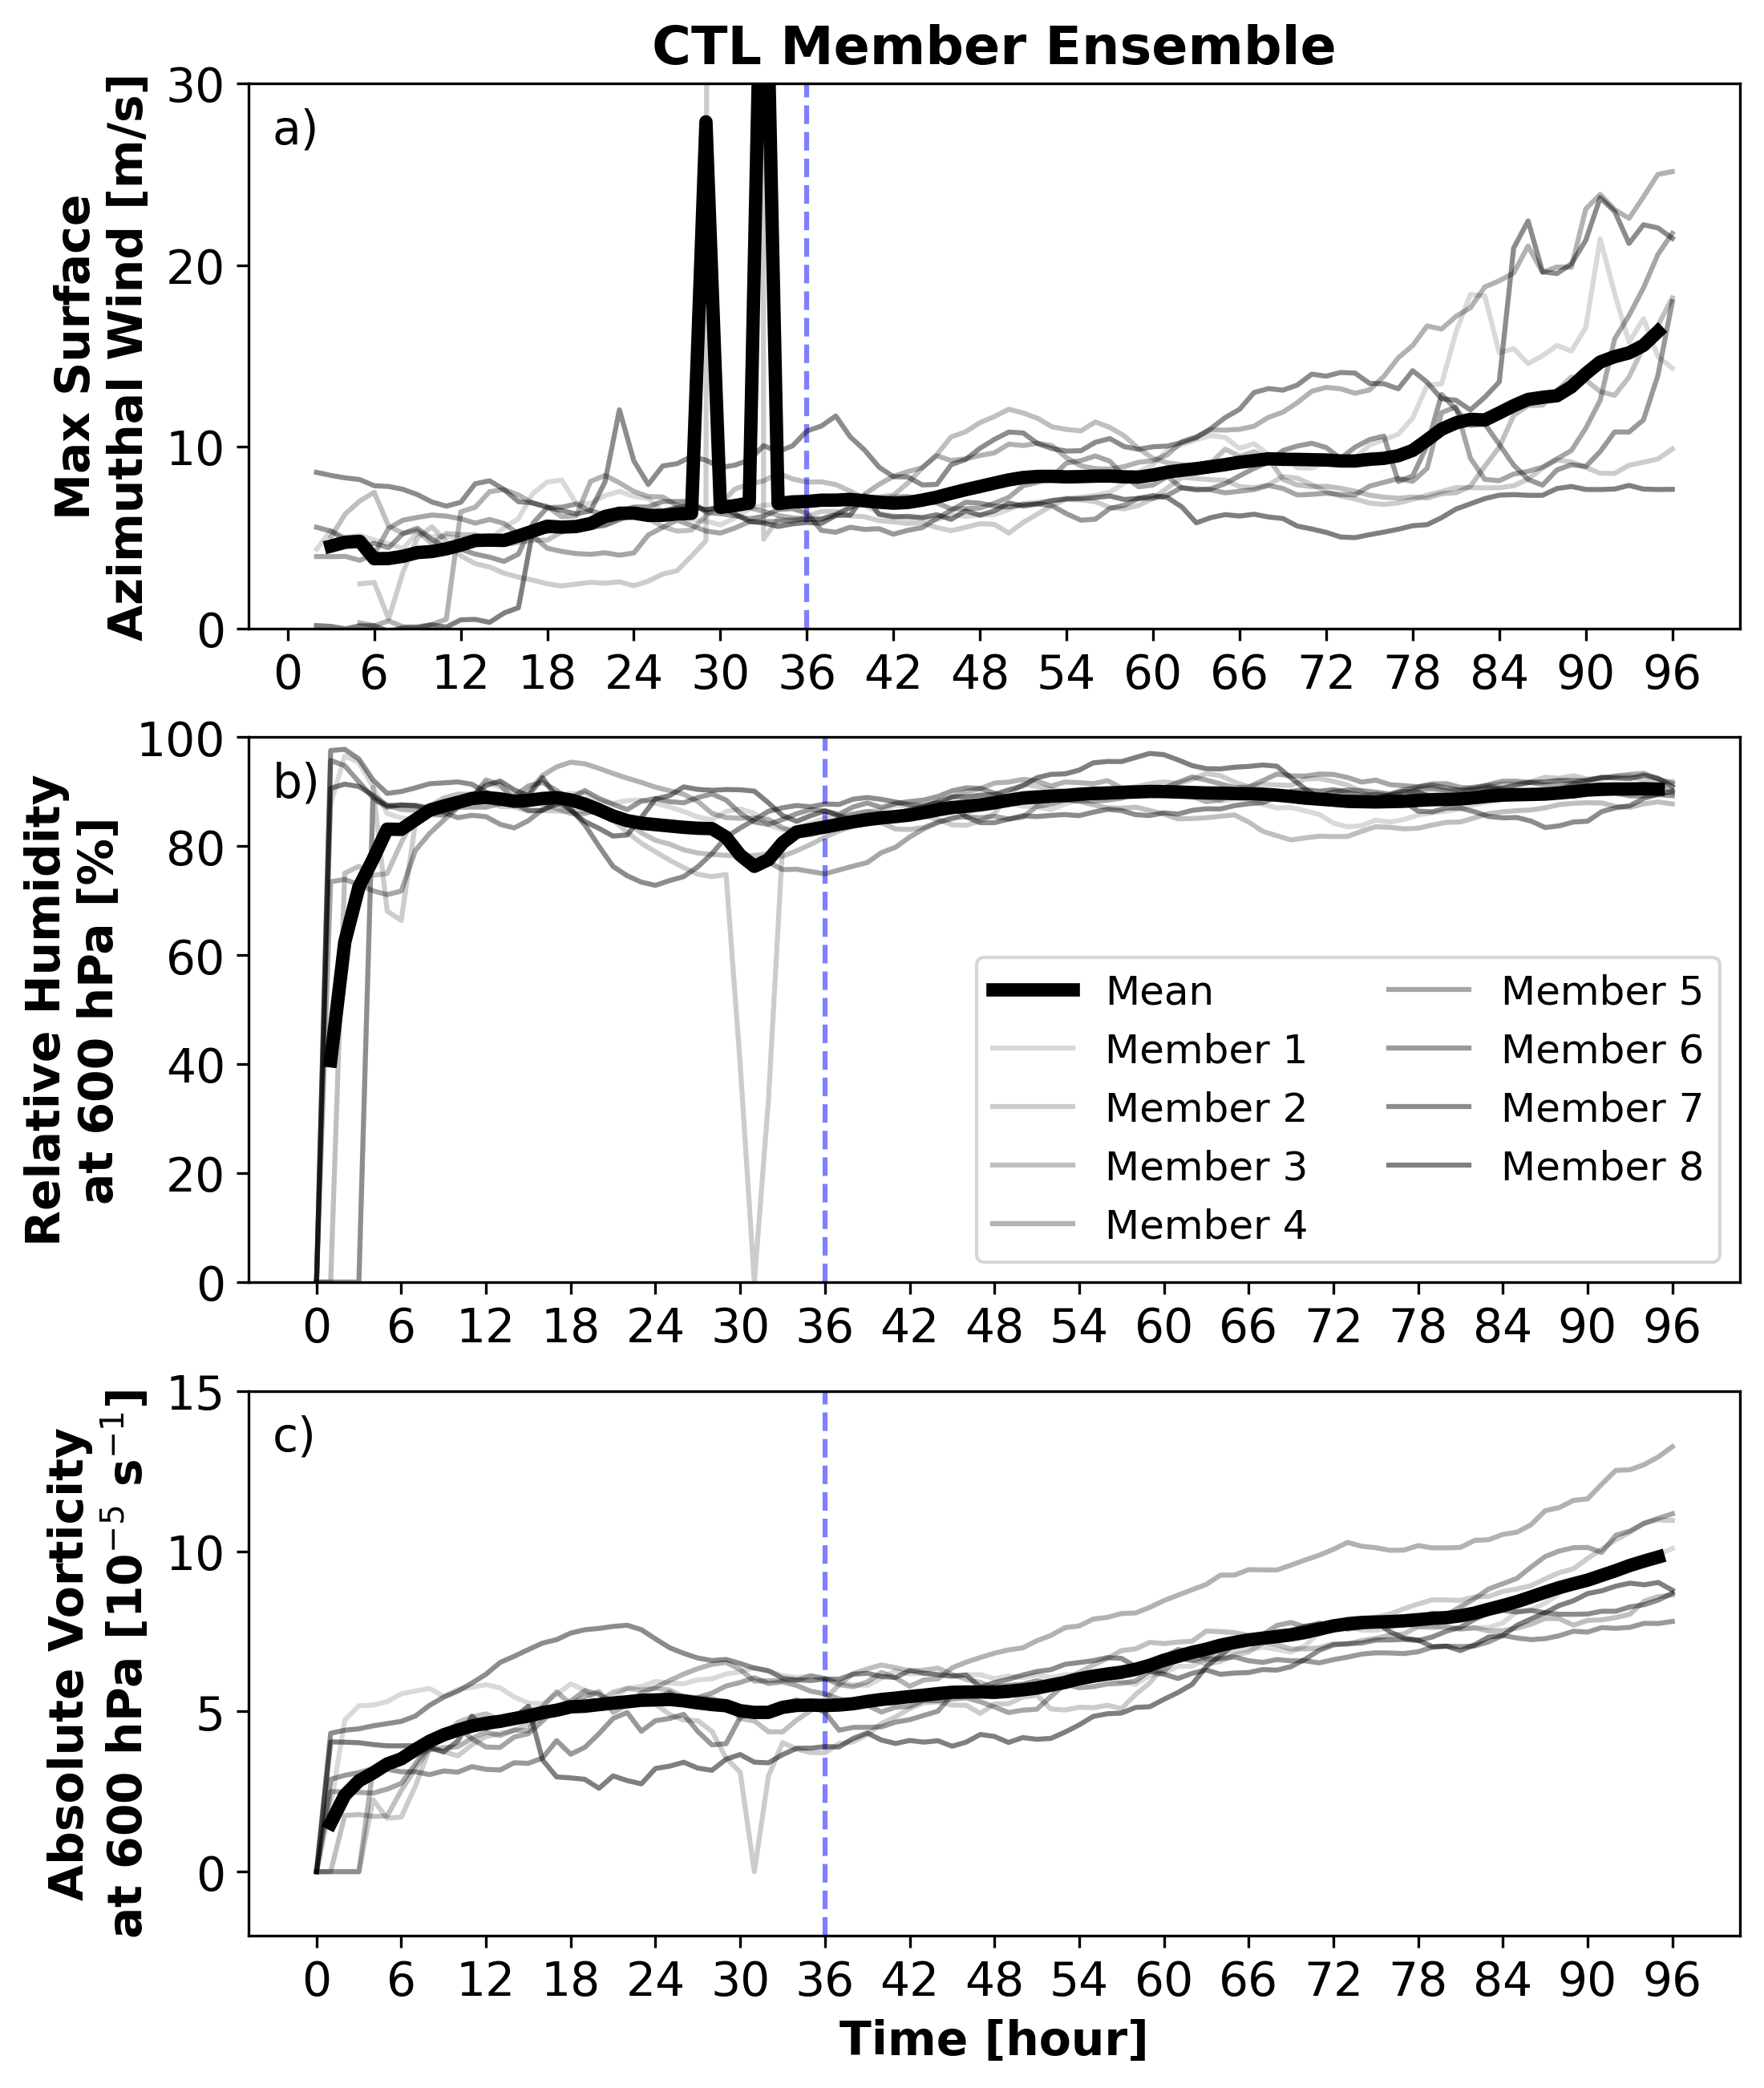

In [12]:
# SI By member Plots

time_plt = np.arange(0,97,1)
a = np.arange(0.15,0.65,0.05)
label_list = ['a)', 'b)', 'c)']
var_list = [azwind_membs_ctl, rh_mean_ctl, avor_mean_ctl]
ntime = 97

fig = plt.figure(figsize=(8,10), dpi=300)
axs = fig.subplots(3,1)
for v in range(nvar):
    ax = axs[v]
    var = var_list[v]
    if v == 0:
        ylabel = 'Max Surface\nAzimuthal Wind [m/s]'
        varlab = '[m/s]'
        ens_mem_smooth = np.zeros((nmem,ntime-2))*np.nan
        for m in range(0,nmem):
            ens_mem_smooth[m,:] = np.convolve(var[m,:], (np.ones(w)/w), mode='valid') # smooth average
        ens_ctl = np.nanmean(ens_mem_smooth, axis=0)
        varmax = 30
        varmin = 0
    elif v == 1:
        ylabel = 'Relative Humidity\nat 600 hPa [%]'
        varlab = '[%]'
        ens_mem_smooth = np.zeros((nmem,ntime-2))*np.nan
        for m in range(0,nmem):
            ens_mem_smooth[m,:] = np.convolve(var[m,:], (np.ones(w)/w), mode='valid') # smooth average
        ens_ctl = np.nanmean(ens_mem_smooth, axis=0)
        varmax = 100
        varmin = 0

    elif v == 2:
        ylabel = 'Absolute Vorticity\nat 600 hPa [10$^{-5}$ s$^{-1}$]'
        varlab = '[10$^{-5}$ s$^{-1}$]'
        ens_mem_smooth = np.zeros((nmem,ntime-2))*np.nan
        for m in range(0,nmem):
            ens_mem_smooth[m,:] = np.convolve(var[m,:], (np.ones(w)/w), mode='valid') # smooth average
        ens_ctl = np.nanmean(ens_mem_smooth, axis=0)
        varmax = 15
        varmin = -2

    ax.axvline(x=36, color='b', linestyle='--', alpha=0.5)
    ax.plot(time_plt[1:-1],ens_ctl, label='Mean', color='k',linewidth=4)

    for m in range(0,nmem):
        if v == 0:
            ax.plot(time_plt,var[m,:], color='k', alpha=a[m], label='Member '+str(m+1))
            # ax.legend(loc='upper left', ncol=2, fontsize=12)
            ax.set_title('CTL Member Ensemble', weight='bold',size=16)
        elif v == 2:
            ax.plot(time_plt,var[m,:], color='k', alpha=a[m], label='Member '+str(m+1))
            ax.set_xlabel('Time [hour]', weight='bold',size=14)
        else:
            ax.plot(time_plt,var[m,:], color='k', alpha=a[m], label='Member '+str(m+1))
            ax.legend(loc='lower right', ncol=2, fontsize=12)


    t_ticks = np.arange(0, 97, 6)
    ax.set_xticks(t_ticks, labels=list(np.arange(0,97,6)))
    ax.tick_params(labelsize=14)
    ax.set_ylim(varmin, varmax)
    ax.set_ylabel(ylabel, weight='bold',size=14)
    ax.annotate(label_list[v], xy=(0, 1), xycoords='axes fraction', xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize=14, verticalalignment='top')
plt.subplots_adjust(hspace=0.2)